In [ ]:
!wget --show-progress --continue -O /content/shakespeare.txt http://www.gutenberg.org/files/100/100-0.txt

--2023-08-06 11:02:48--  http://www.gutenberg.org/files/100/100-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/files/100/100-0.txt [following]
--2023-08-06 11:02:48--  https://www.gutenberg.org/files/100/100-0.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
!head -n5 /content/shakespeare.txt
!echo "..."
!shuf -n5 /content/shakespeare.txt

﻿The Project Gutenberg eBook of The Complete Works of William Shakespeare, by William Shakespeare

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
...
GUIDERIUS.
Dat it is not be de fashion _pour les_ ladies of France,—I cannot tell
    When she will play with reason and discourse,

ARMADO.


In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as tl
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import distutils
if distutils.version.LooseVersion(tf.__version__) < '2.0':
    raise Exception('This notebook is compatible with TensorFlow 2.0 or higher.')

<ipython-input-125-d48a0b8861bc>:16: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(tf.__version__) < '2.0':


In [ ]:
Shakespeare_txt='/content/shakespeare.txt'

def transform(txt):
  return np.array([ord(c) for c in txt if ord(c)<255],dtype=np.int32)

def input_fn(seq_len=100,batch_size=1024):
  with tf.io.gfile.GFile(Shakespeare_txt,'r') as f:
    txt=f.read()

  source=tf.constant(transform(txt),dtype=np.int32)

  ds=tf.data.Dataset.from_tensor_slices(source).batch(seq_len+1, drop_remainder=True)

  def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

  BUFFER_SIZE = 10000
  ds = ds.map(split_input_target).shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)

  return ds.repeat()

In [ ]:
Embedding_dim=1024

def Create_model(seq_len=100,batch_size=None,stateful=True):
  source=tf.keras.Input(name='seed',shape=(seq_len,),batch_size=batch_size,dtype=tf.int32)
  embedding=tl.Embedding(input_dim=256,output_dim=Embedding_dim)(source)
  lstm_1=tl.LSTM(Embedding_dim,stateful=stateful,return_sequences=True)(embedding)
  lstm_2=tl.LSTM(Embedding_dim,stateful=stateful,return_sequences=True)(lstm_1)
  predicted_char=tl.TimeDistributed(tl.Dense(256,activation='softmax'))(lstm_2)
  return tf.keras.Model(inputs=[source],outputs=[predicted_char])

In [ ]:
# TPU runtime only
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

lr_schedule=ExponentialDecay(
    0.01,
    500,
    0.96
)

with strategy.scope():
  training_model = Create_model(seq_len=100, stateful=False)
  training_model.compile(
      optimizer=tf.keras.optimizers.RMSprop(lr_schedule),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])

In [ ]:
history = training_model.fit(
    input_fn(),
    steps_per_epoch=100,
    epochs=50
)
training_model.save_weights('/tmp/bard.h5', overwrite=True)

Epoch 1/50
100/100 [==============================] - 16s 156ms/step - loss: 1.1702 - sparse_categorical_accuracy: 0.6309
Epoch 2/50
100/100 [==============================] - 16s 157ms/step - loss: 1.1651 - sparse_categorical_accuracy: 0.6324
Epoch 3/50
100/100 [==============================] - 16s 157ms/step - loss: 1.1644 - sparse_categorical_accuracy: 0.6323
Epoch 4/50
100/100 [==============================] - 16s 157ms/step - loss: 1.1602 - sparse_categorical_accuracy: 0.6336
Epoch 5/50
100/100 [==============================] - 16s 157ms/step - loss: 1.1566 - sparse_categorical_accuracy: 0.6347
Epoch 6/50
100/100 [==============================] - 16s 157ms/step - loss: 1.1515 - sparse_categorical_accuracy: 0.6360
Epoch 7/50
100/100 [==============================] - 16s 157ms/step - loss: 1.1488 - sparse_categorical_accuracy: 0.6368
Epoch 8/50
100/100 [==============================] - 16s 157ms/step - loss: 1.1448 - sparse_categorical_accuracy: 0.6378
Epoch 9/50
100/100 [====

KeyboardInterrupt: ignored

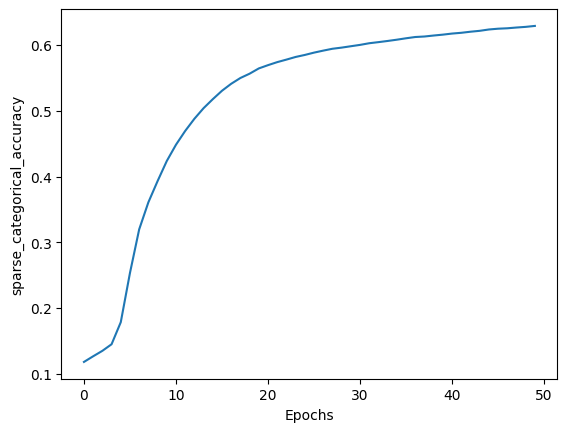

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, "sparse_categorical_accuracy")
# plot_graphs(history, "loss")

In [ ]:
Batch_size=5
Predict_len=250

prediction_model=Create_model(seq_len=1,batch_size=Batch_size,stateful=True)
prediction_model.load_weights('/tmp/bard.h5')

seed_text='I love you, i love you so much'
seed=transform(seed_text)
seed=np.repeat(np.expand_dims(seed,0),Batch_size,axis=0)

prediction_model.reset_states()
for i in range(len(seed_text)-1):
  prediction_model.predict(seed[:,i:i+1])

1/1 [==============================] - 0s 34ms/step


In [ ]:
predictions=[seed[:, -1:]]
for i in range(Predict_len):
  last_word=predictions[-1]
  next_probits=prediction_model.predict(last_word)[:,0,:]

  next_idx=[
      np.random.choice(256,p=next_probits[i]) for i in range(Batch_size)
  ]

  predictions.append(np.reshape(np.asarray(next_idx,dtype=np.int32),[Batch_size,1]))

1/1 [==============================] - 0s 33ms/step


In [ ]:
for i in range(Batch_size):
  print('PREDICTION %d\n\n' % i)
  p=[predictions[j][i] for j in range(Predict_len)]
  generated=''.join([chr(int(c)) for c in p])
  print(generated)
  print()
  assert len(generated) == Predict_len, 'Generated text too short'

PREDICTION 0


h friends.
Then cannot speak tops head and miscreardiness,
Whose fathers shade or this! Good follow, they inkly indeed,
Received hath beauty great King, will have bold readed with a beauties he,
Ere when you befall my husbers nose to bring you.


PREDICTION 1


h to heaven
Should have conspired you to mine, and what is a
Would say that hath pulcain tressd here? The Duke of Somerset
I; Exlumnorlanes are in every lord.

BRUTUS.
Costard with labour, mean men; we brought her wife and hear
Is in my sovere

PREDICTION 2


h assemble,
To gy drum as they did it be he appear
Within his hand, if your head shall lead, nor speak.
Go please your head. So, you have all the wheels the course too.

ROSALINE.
Tell him that wait, that I will not say with case lies renew blo

PREDICTION 3


h a cunning-gac'd mate. A rail in a mask.

BELARIUS.
O my daughters!

 [_Hoadses part of them. Cursud Cassius._]

O, most poor meat!

THIRD GENTLEMAN.
Look, heavens, Mars, my cousin Tribunes.

AJAX.
Wil

<ipython-input-134-9a280956c676>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  generated=''.join([chr(int(c)) for c in p])


In [ ]:
# bucketing, techer forecing
# not here, it in seq2seq model